In [1]:
import IPython
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly as py
from plotly.offline import download_plotlyjs
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

np.random.seed(1337)

%matplotlib inline

IPython.core.display.display(IPython.core.display.HTML(
    "<style>.container { width:90% !important; }</style>"))

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

pd.options.display.max_colwidth = 30
pd.options.display.float_format = '{:,.3f}'.format

py.offline.init_notebook_mode(connected=True)

## Load the data

In [2]:
movies = pd.read_csv('data/movies_clean.csv')
ratings = pd.read_csv('data/ratings_train.csv')

## Compute scores

In [3]:
# calculate descriptive statistics about the ratings of each movie
movie_scores = ratings.groupby(['movie_id']).rating.agg(['count', 'mean', 'std'])
movie_scores.columns = ['ratings_cnt', 'ratings_avg', 'ratings_std']
movie_scores.sample(10)

,ratings_cnt,ratings_avg,ratings_std
movie_id,,,
93911,1,3.000,nan
94044,7,3.214,1.254
127831,1,3.500,nan
66927,4,4.000,0.913
70521,93,3.656,0.970
33358,131,3.660,0.912
99679,4,2.750,1.658
104633,1,3.500,nan
333,8780,3.348,1.065


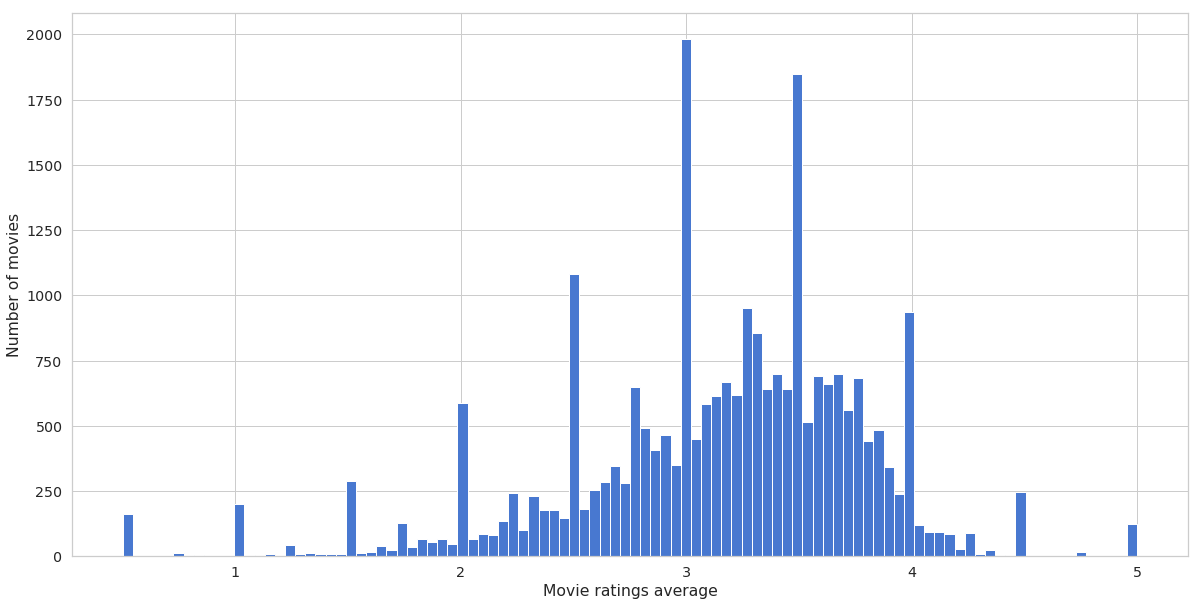

In [4]:
plt.figure(figsize=(20, 10))
plt.hist(movie_scores.ratings_avg.dropna(), bins=100)
plt.xlabel('Movie ratings average')
plt.ylabel('Number of movies')
plt.show()

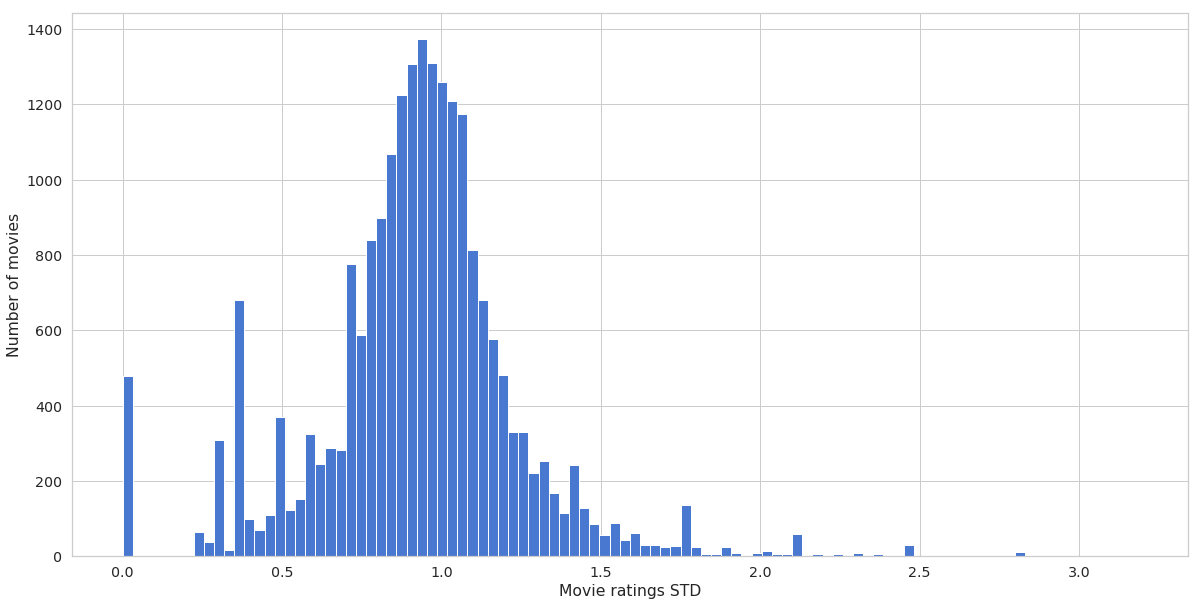

In [5]:
plt.figure(figsize=(20, 10))
plt.hist(movie_scores.ratings_std.dropna(), bins=100)
plt.xlabel('Movie ratings STD')
plt.ylabel('Number of movies')
plt.show()

In [6]:
# calculate quantiles of ratings average and STD
movie_scores['ratings_avg_qcut'] = pd.qcut(
    movie_scores.ratings_avg + (0.0001 * np.random.randn(len(movie_scores))),
    1000,
    labels=range(1, 1001)).astype(float)
movie_scores['ratings_std_qcut'] = pd.qcut(
    movie_scores.ratings_std + (0.0001 * np.random.randn(len(movie_scores))),
    1000,
    labels=range(1, 1001)).astype(float)

In [7]:
movies = pd.merge(movies, movie_scores, left_on='movie_id', right_index=True)
movies['age'] = 2019 - movies.year
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25871 entries, 0 to 27277
Data columns (total 30 columns):
movie_id                25871 non-null int64
title                   25871 non-null object
year                    25852 non-null float64
parsed_genres           25871 non-null object
genre_nogenreslisted    25871 non-null int64
genre_scifi             25871 non-null int64
genre_horror            25871 non-null int64
genre_thriller          25871 non-null int64
genre_documentary       25871 non-null int64
genre_filmnoir          25871 non-null int64
genre_children          25871 non-null int64
genre_romance           25871 non-null int64
genre_mystery           25871 non-null int64
genre_western           25871 non-null int64
genre_fantasy           25871 non-null int64
genre_imax              25871 non-null int64
genre_drama             25871 non-null int64
genre_adventure         25871 non-null int64
genre_comedy            25871 non-null int64
genre_war               25871 no

In [8]:
movies.sample(5).T

,8429,7911,25277,1041,19691
movie_id,25854,8594,119196,1061,97395
title,Intermezzo (1939),"Secret Life of Girls, The ...",Heartbeat (1938),Sleepers (1996),West of Memphis (2012)
year,"1,939.000","1,999.000","1,938.000","1,996.000","2,012.000"
parsed_genres,"['drama', 'romance']",['comedy'],['comedy'],['thriller'],['documentary']
genre_nogenreslisted,0,0,0,0,0
genre_scifi,0,0,0,0,0
genre_horror,0,0,0,0,0
genre_thriller,0,0,0,1,0
genre_documentary,0,0,0,0,1
genre_filmnoir,0,0,0,0,0


## Some charts

### Top rated horror movies

In [9]:
print(movies[movies.genre_horror == 1].ratings_cnt.quantile([0.8 + i*0.05 for i in range(5)]))

0.800      254.000
0.850      452.850
0.900      913.700
0.950    1,998.250
1.000   50,666.000
Name: ratings_cnt, dtype: float64


In [10]:
d = movies[(movies.genre_horror == 1) & (movies.ratings_cnt > 1000)].copy()
d['score'] = (
    + 1.0 * d.ratings_avg_qcut
    - 0.1 * d.ratings_std_qcut
    + 0.001 * d.ratings_cnt)
d = d.sort_values(by='score', ascending=False)
d.head(30)[['movie_id', 'title', 'year', 'parsed_genres', 'ratings_avg', 'ratings_avg_qcut', 'ratings_std', 'ratings_std_qcut', 'ratings_cnt', 'score']]

,movie_id,title,year,parsed_genres,ratings_avg,ratings_avg_qcut,ratings_std,ratings_std_qcut,ratings_cnt,score
587,593,"Silence of the Lambs, The ...","1,991.000","['crime', 'horror', 'thril...",4.178,979.000,0.840,329.000,50666,996.766
2676,2762,"Sixth Sense, The (1999)","1,999.000","['drama', 'horror', 'myste...",4.054,969.000,0.830,313.000,31301,969.001
1188,1214,Alien (1979),"1,979.000","['horror', 'scifi']",4.036,967.000,0.887,409.000,24692,950.792
1193,1219,Psycho (1960),"1,960.000","['crime', 'horror']",4.075,970.000,0.860,360.000,15677,949.677
1230,1258,"Shining, The (1980)","1,980.000",['horror'],4.011,964.000,0.882,401.000,18744,942.644
1175,1200,Aliens (1986),"1,986.000","['action', 'adventure', 'h...",4.002,963.000,0.897,426.000,21850,942.250
12932,61240,Let the Right One In (Låt ...,"2,008.000","['drama', 'fantasy', 'horr...",4.019,965.000,0.820,298.000,2457,937.657
8191,8874,Shaun of the Dead (2004),"2,004.000","['comedy', 'horror']",3.908,915.000,0.849,341.000,9337,890.237
6875,6987,"Cabinet of Dr. Caligari, T...","1,920.000","['crime', 'fantasy', 'horr...",3.917,918.000,0.899,429.000,1110,876.210
1318,1348,"Nosferatu (Nosferatu, eine...","1,922.000",['horror'],3.911,916.000,0.944,516.000,2959,867.359


### Controversial horror movies

In [11]:
print(movies[movies.genre_horror == 1].ratings_cnt.quantile([0.8 + i*0.05 for i in range(5)]))

0.800      254.000
0.850      452.850
0.900      913.700
0.950    1,998.250
1.000   50,666.000
Name: ratings_cnt, dtype: float64


In [12]:
d = movies[(movies.genre_horror == 1) & (movies.ratings_cnt > 1000)].copy()
d['score'] = (
    + 1.0 * d.ratings_avg_qcut
    + 2.0 * d.ratings_std_qcut
    + 0.001 * d.ratings_cnt)
d = d.sort_values(by='score', ascending=False)
d.head(30)[['movie_id', 'title', 'year', 'parsed_genres', 'ratings_avg', 'ratings_avg_qcut', 'ratings_std', 'ratings_std_qcut', 'ratings_cnt', 'score']]

,movie_id,title,year,parsed_genres,ratings_avg,ratings_avg_qcut,ratings_std,ratings_std_qcut,ratings_cnt,score
3585,3676,Eraserhead (1977),"1,977.000","['drama', 'horror']",3.601,767.000,1.177,858.000,2068,"2,485.068"
1213,1241,Dead Alive (Braindead) (1992),"1,992.000","['comedy', 'fantasy', 'hor...",3.727,837.000,1.094,779.000,2042,"2,397.042"
2571,2657,"Rocky Horror Picture Show,...","1,975.000","['comedy', 'horror', 'musi...",3.328,562.000,1.218,885.000,10778,"2,342.778"
1233,1261,Evil Dead II (Dead by Dawn...,"1,987.000","['action', 'comedy', 'fant...",3.774,865.000,1.061,735.000,6211,"2,341.211"
1898,1982,Halloween (1978),"1,978.000",['horror'],3.543,733.000,1.108,794.000,5085,"2,326.085"
2374,2459,"Texas Chainsaw Massacre, T...","1,974.000",['horror'],3.202,485.000,1.293,917.000,2438,"2,321.438"
951,968,Night of the Living Dead (...,"1,968.000","['horror', 'scifi', 'thril...",3.628,783.000,1.084,766.000,6425,"2,321.425"
2465,2550,"Haunting, The (1963)","1,963.000","['horror', 'thriller']",3.619,776.000,1.083,765.000,1221,"2,307.221"
8274,8957,Saw (2004),"2,004.000","['horror', 'mystery', 'thr...",3.456,644.000,1.126,813.000,4384,"2,274.384"
1913,1997,"Exorcist, The (1973)","1,973.000","['horror', 'mystery']",3.747,845.000,1.044,701.000,10731,"2,257.731"
